In [346]:
import pandas as pd

# 1. Load data

In [482]:
data = pd.read_csv('/home/labhhc/Documents/Project/CADD_package/Data_preprocess/Data/CHEMBL4247.csv', sep=';')
data.head(5)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL4213237,NaN,None,286.46,0,2.19,7'e,CCCCCCCCCCCNC[C@@H]1OC[C@H](N)[C@H]1O,IC50,'=',...,A549,Homo sapiens,CELL-LINE,CHEMBL4184090,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,CHEMBL3307651,NaN
1,CHEMBL4204703,NaN,None,308.39,0,3.34,"13, SLV 320",O[C@H]1CC[C@H](Nc2nc(-c3ccccc3)nc3[nH]ccc23)CC1,Activity,'=',...,A549,Homo sapiens,CELL-LINE,CHEMBL4184095,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,CHEMBL3307651,NaN
2,CHEMBL136689,NaN,None,389.42,0,2.96,"15, SCH 442416",COc1ccc(CCCn2ncc3c2nc(N)n2nc(-c4ccco4)nc32)cc1,Activity,'=',...,A549,Homo sapiens,CELL-LINE,CHEMBL4184095,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,CHEMBL3307651,NaN
3,CHEMBL483688,NaN,None,529.02,1,2.65,"16, PSB 603",CCCn1c(=O)[nH]c2nc(-c3ccc(S(=O)(=O)N4CCN(c5ccc...,Activity,'=',...,A549,Homo sapiens,CELL-LINE,CHEMBL4184095,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,CHEMBL3307651,NaN
4,CHEMBL4218062,NaN,None,523.59,1,2.81,30,CN(C)CCCNc1cc2nc(/C=C3\C(=O)Nc4cc(N5CCN(C)CC5)...,IC50,'=',...,A549,Homo sapiens,CELL-LINE,CHEMBL4177752,1,Scientific Literature,J Med Chem,2018.0,CHEMBL3307651,NaN


In [483]:
data.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

# 2. FLOW

In [484]:
columns = ['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment',
          'Assay Type', 'Assay Description','Assay Organism', 'Assay Variant Mutation','Target Name','Target Organism', 'Document Journal']

df = data[columns]

In [485]:
df['Target Name'].unique()

array(['A549'], dtype=object)

In [486]:
df['Target Organism'].unique()

array(['Homo sapiens'], dtype=object)

## 2.1. Target value standardize (Standard)

In [487]:
class target_curate:
    def __init__(self, data, target_name_col, target_name, target_org_col, target_org,
                 type_col, unit_col, active_col, relate_col, type_arg,equal_only = False, thresh = 7):
        self.data = data.reset_index(drop=True)
        self.target_name_col = target_name_col 
        self.target_name = target_name
        self.target_org_col=target_org_col
        self.target_org = target_org
        self.type_col = type_col
        self.unit_col = unit_col
        self.active_col = active_col
        self.relate_col = relate_col
        self.type_arg = type_arg
        self.equal_only = equal_only
        self.thresh = thresh
        
    def target_filter(self, data, target_name_col, target_name, target_org_col, target_org):
        df= data[data[target_name_col]==target_name]
        display(df.shape)
        df2 = df[df[target_org_col]==target_org]
        display(df2.shape)
        return df2
    def standardize_value(self, data, type_col, type_arg, unit_col):
        df = data[data[type_col]==type_arg]
        df= df.dropna(subset =unit_col)
        df.reset_index(drop=True, inplace = True)
        type = ['μM','µM', 'nM', 'mM', 'M', 'nmol/l']
        idx = []
        for key, value in enumerate(df[unit_col]):
            if value in type:
                idx.append(key)
        df = df.iloc[idx,:]
        return df
    
    def convert_activity(self, data, active_col, unit_col):
        df = data.copy()
        df['pChEMBL'] = np.zeros(len(df))
        #unit = df['Unit'].unique()

        for key, value in enumerate(df[unit_col]):
            if value == 'μM':
                df.loc[key, 'pChEMBL'] = -np.log10(df.loc[key, active_col]*1e-6)
            elif value  == 'µM':
                df.loc[key, 'pChEMBL'] = -np.log10(df.loc[key, active_col]*1e-6)
            elif value  == 'nM':
                df.loc[key, 'pChEMBL'] = -np.log10(df.loc[key, active_col]*1e-9)
            elif value  == 'nmol/l':
                df.loc[key, 'pChEMBL'] = -np.log10(df.loc[key, active_col]*1e-9)
            elif value  == 'mM':
                df.loc[key, 'pChEMBL'] = -np.log10(df.loc[key, active_col]*1e-3)
            elif value  == 'M':
                df.loc[key, 'pChEMBL'] = -np.log10(df.loc[key, active_col]*1)
            elif value  == 'no unit':
                df.loc[key, 'pChEMBL'] = -df.loc[key, active_col]
        return df
    
    
    def standardize_relation(self, data,relate_col,  equal_only, thresh):
        df = data.copy()
        df.dropna(subset = relate_col, inplace = True)
        if equal_only == True:
            print('SELECTING ONLY EQUAL')
            df = df[df[relate_col]=="'='"]
            
        else:
            print('HANDLING')
            df_big = df[(df[relate_col] == "'>'") | (df[relate_col] == "'>='")]
            df_small = df[(df[relate_col] == "'<'") | (df[relate_col] == "'<='")]
            df_equal = df[df[relate_col]=="'='"]
                
            #Drop pCHEMBL < thresh for df_big
            drop_idx = df_big[df_big["pChEMBL"] < thresh].index
            df_big.drop(drop_idx, inplace = True)
                
            #Drop pCHEMBL > thresh for df_small
            drop_idx = df_small[df_small["pChEMBL"] > thresh].index
            df_small.drop(drop_idx, inplace = True)
                
            df = pd.concat((df_equal, df_small, df_big), axis = 0)
        return df
                  
    def curated_fit(self):
        print("Number of data before target curation:", self.data.shape[0])
        df = self.target_filter(data = self.data, target_name_col = self.target_name_col, target_name =self.target_name, 
                           target_org_col=self.target_org_col, target_org = self.target_org)
        print("Number of data after handle organism and target name:", df.shape[0])
        df1 = self.standardize_value(data=df, type_col=self.type_col, type_arg=self.type_arg, unit_col=self.unit_col)
        df1.reset_index(drop=True, inplace = True)
        print("Number of data after select unit:", df1.shape[0])
        #display(df.head(5))
        df2 = self.convert_activity(data=df1, active_col=self.active_col, unit_col = self.unit_col)
        df2.reset_index(drop=True, inplace = True)
        #display(df2.head(5))
        df3 = self.standardize_relation(data=df2,relate_col=self.relate_col,  equal_only=self.equal_only, thresh=self.thresh)
        self.df = df3
        print("Number of data after standardizing:", self.df.shape[0])
        
        

In [488]:
target = target_curate(data =df, target_name_col = 'Target Name', target_name ='MDA-MB-231', target_org_col='Target Organism', target_org = 'Homo sapiens',
                            type_col='Standard Type', unit_col='Standard Units', active_col='Standard Value', 
                            relate_col='Standard Relation', type_arg ='IC50',equal_only = False, thresh = 7)
target.curated_fit()

Number of data before target curation: 69180


(69180, 15)

(69180, 15)

Number of data after handle organism and target name: 69180
Number of data after select unit: 17659
HANDLING
Number of data after standardizing: 13787


/tmp/ipykernel_675207/1475208806.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_big.drop(drop_idx, inplace = True)
/tmp/ipykernel_675207/1475208806.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.drop(drop_idx, inplace = True)


In [489]:
df1 = target.df

## 2.2. Assay

In [490]:
class assay_curate:
    def __init__(self,data, type_col, org_col,des_col, type_arg='F', org_arg='Homo sapiens', kw = 'MTT'):
        self.data = data
        self.type_col = type_col
        self.org_col = org_col
        self.des_col = des_col
        self.type_arg= type_arg
        self.org_arg= org_arg
        self.kw = kw 
    
    def search_kw(self, data,kw, des_col):
        index = []
        for key, value in enumerate(data[des_col]):
            if kw in value:
                index.append(key)
        return data.iloc[index,:]
    
    def curated_fit(self):
        print("Number of data befor standardizing:", self.data.shape[0])
        df = self.data[self.data[self.type_col]==self.type_arg]
        print("Number of data after choosing assay type:", df.shape[0])
        df2 = df[df[self.org_col]==self.org_arg]
        print("Number of data after choosing assay organism:", df2.shape[0])
        df3 = self.search_kw(data=df2, kw = self.kw, des_col = self.des_col)
        print("Number of data after curating:", df3.shape[0])
        self.df = df3

In [491]:
assay = assay_curate(data=df1, type_col="Assay Type", org_col="Assay Organism",des_col='Assay Description', 
                     type_arg='F', org_arg='Homo sapiens', kw = 'MTT')

assay.curated_fit()

Number of data befor standardizing: 13787
Number of data after choosing assay type: 13715
Number of data after choosing assay organism: 13715
Number of data after curating: 8104


In [492]:
df2 = assay.df
df2.shape

(8104, 16)

## 2.3. Smiles curated

In [493]:
class smile_curate:
    def __init__(self, data, smile_col, pchem_col, keep = 'best'):
        self.data = data
        self.smile_col = smile_col
        self.pchem_col = pchem_col
        self.keep = keep
    def smile_norm(data, smile_col):
        df = data.dropna(subset = smile_col)
        df['Canonical_Smiles'] = df[smile_col].apply(Chem.CanonSmiles)
        return df
    def curate(self):
        df = smile_norm(data=self.data, smile_col=self.smile_col)
        if self.keep == 'best':
            df = df.sort_values(by=self.pchem_col, ascending=False)
            df_dropdup = df.drop_duplicates(subset=['Canonical_Smiles'], keep="first")
        elif self.keep == 'worst':
            df = df.sort_values(by=self.pchem_col, ascending=True)
            df_dropdup = df.drop_duplicates(subset=['Canonical_Smiles'], keep="first")
           
        print(df_dropdup.shape)
        self.df = df_dropdup

In [494]:
smile = smile_curate(data=df2, smile_col='Smiles', pchem_col='pChEMBL', keep = 'best')
smile.curate()

(7427, 17)


In [495]:
df3 = smile.df

In [496]:
df3.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Assay Type,Assay Description,Assay Organism,Assay Variant Mutation,Target Name,Target Organism,Document Journal,pChEMBL,Canonical_Smiles
1211,CHEMBL2321905,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...,IC50,'=',0.000065,nM,NaN,Outside typical range,F,Cytotoxicity against human MDA-MB-231 cells af...,Homo sapiens,NaN,MDA-MB-231,Homo sapiens,J Med Chem,13.187087,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...
11280,CHEMBL2324630,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...,IC50,'=',0.000180,nM,NaN,Outside typical range,F,Cytotoxicity against human MDA-MB-231 cells af...,Homo sapiens,NaN,MDA-MB-231,Homo sapiens,J Med Chem,12.744727,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...
9029,CHEMBL218105,COc1cc(/C=C/C(=O)O)ccc1OCC=C(C)C,IC50,'=',0.000800,nM,NaN,Outside typical range,F,Antiproliferative activity against human MDA-M...,Homo sapiens,NaN,MDA-MB-231,Homo sapiens,J Nat Prod,12.096910,COc1cc(/C=C/C(=O)O)ccc1OCC=C(C)C
6216,CHEMBL2324629,COC(=O)c1nc(NC(=O)c2cc(NC(=O)c3cc(-c4ccc(NC(=O...,IC50,'=',0.015000,nM,10.82,NaN,F,Cytotoxicity against human MDA-MB-231 cells af...,Homo sapiens,NaN,MDA-MB-231,Homo sapiens,J Med Chem,10.823909,COC(=O)c1nc(NC(=O)c2cc(NC(=O)c3cc(-c4ccc(NC(=O...
11466,CHEMBL215032,COC(=O)c1cc(NC(=O)c2cc(NC(=O)CCCOc3cc4c(cc3OC)...,IC50,'=',0.120000,nM,9.92,NaN,F,Cytotoxicity against human MDA-MB-231 cells af...,Homo sapiens,NaN,MDA-MB-231,Homo sapiens,J Med Chem,9.920819,COC(=O)c1cc(NC(=O)c2cc(NC(=O)CCCOc3cc4c(cc3OC)...


## 2.4. pChEMBL

In [497]:
df4 = df3.dropna(subset = 'pChEMBL Value')
df4.shape

(7232, 17)

In [498]:
import seaborn as sns
import matplotlib.pyplot as plt

R2= 0.9999890666199683


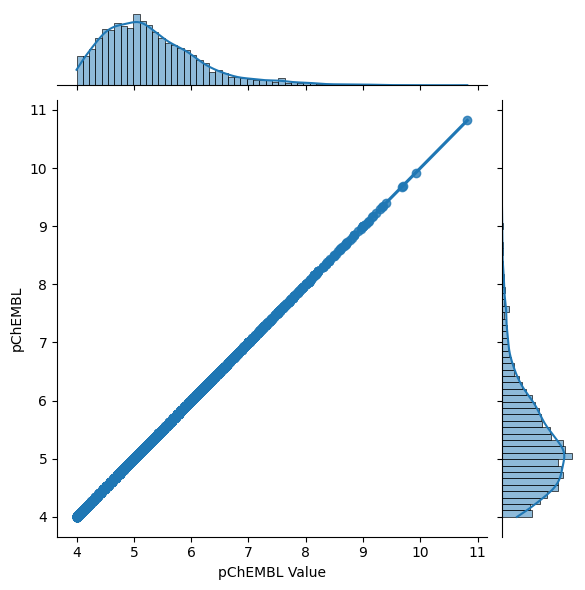

In [499]:
import seaborn as sns
import numpy as np

x, y = df4["pChEMBL Value"].values, df4["pChEMBL"].values
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
r2=stats.pearsonr(x, y)[0] ** 2
print('R2=', r2)

sns.jointplot(data = df4, 
    x = "pChEMBL Value",
    y = "pChEMBL", kind="reg")


## 2.5. Save

In [500]:
df3.to_csv('MDAMB231.csv')
df4.to_csv('MDAMB231_pchem.csv')